## NeRF: Neural Radiance Field

This seminar is largely borrowed from [Deep Vision and Graphics course](https://github.com/yandexdataschool/deep_vision_and_graphics) @ YSDA.

**NB:** The implementation below is naive and slow. It is recommended to execute Run All first before diving into the explainations.

Let's start with a teaser...

In [1]:
from IPython.display import HTML

HTML(
    """
    <video alt="nerf_vid" width="500" controls>
        <source src="http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/website_renders/colorspout_200k_rgb.mp4" type="video/mp4">
    </video>
"""
)

### Downloading & importing stuff

In [2]:
# !mkdir -p data
# !cd data
# !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
# !unzip nerf_example_data.zip
# !cd ..
# !wget https://www.dropbox.com/s/s8j1t1wmf92jhf4/nerf-helper.py
# !mv nerf-helper.py nerf_helper.py

In [3]:
# !wget https://www.dropbox.com/s/s8j1t1wmf92jhf4/nerf-helper.py

In [4]:
# # for extreme tpu support ! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
# !pip install pytorch-lightning

In [5]:
import json
import math
import os
import pickle
import time
import warnings

import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nerf_helper import *
from PIL import Image
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings("ignore")

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Volume Rendering
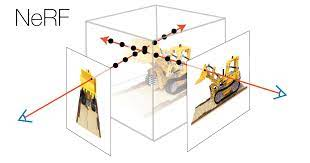

In this tutorial we are not going to implement volume rendering mechanism, but for general understanding we need to see what is generally happening here.

We shoot rays from camera origin through pixels towards the scene. Each ray represents the color of its corresponding pixel. We render the color of any ray passing through the scene using volume rendering. The density $\sigma(x)$  can be interpreted as the differential probability of a
ray terminating at a location x. Mathematically, it shold be a delta function in case of rigid non-transparent surfaces.

The expected color
$C(r)$ of camera ray $r(t) = o + t*d$ ($o$ - from what point and $d$ is the direction of the light) with near and far bounds $t_n$ and $t_f$ is:

$$C(\mathbf{r})=\int_{t_{n}}^{t_{f}} T(t) \sigma({r}(t)) {c}({r}(t), {d}) d t,$$ 
where $T(t)=\exp \left(-\int_{t_{n}}^{t} \sigma({r}(s)) d s\right)$.
Informally $T(t)$ is the probability that the ray goes on and doesn't hit anything,  $\sigma({r}(t))$ shows how much ray stopped at current point and we adopt the color with $c(r(t))$.

The one existing problem here is to compute numerically this integral. For simplicity, we uniformly sample points of depth between near and far bounds. 

![image](https://user-images.githubusercontent.com/20357655/144260820-69d736bc-3dfb-4124-ac84-29d2e5fb7d05.png)

In [7]:
class VolumeRenderer(nn.Module):
    def __init__(
        self,
        train_radiance_field_noise_std=0.0,
        val_radiance_field_noise_std=0.0,
        white_background=False,
        attenuation_threshold=1e-3,
        device="cuda",
    ):
        super(VolumeRenderer, self).__init__()
        self.train_radiance_field_noise_std = train_radiance_field_noise_std
        self.val_radiance_field_noise_std = val_radiance_field_noise_std
        self.attenuation_threshold = attenuation_threshold
        self.use_white_bkg = white_background
        epsilon = torch.tensor([1e10]).to(device)
        epsilon.requires_grad = False
        self.register_buffer("epsilon", epsilon)

    def forward(self, radiance_field, depth_values, ray_directions):
        """
        Perform volume rendering by computing the output of NeRF model ('radiance_field')
        Inputs:
            radiance_field: (torch.tensor): (ray_count, num_samples, 4) rgb and sigma
            depth_values:  (torch.tensor): (ray_count, num_samples) : Depths of the sampled positions along the ray
            ray_directions: (torch.tensor): (ray_count, num_samples, 3)
        Outputs:
            rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
        """

        if self.training:
            radiance_field_noise_std = self.train_radiance_field_noise_std
        else:
            radiance_field_noise_std = self.val_radiance_field_noise_std

        # distance between adjacent samples points.
        deltas = torch.cat(
            (
                depth_values[..., 1:] - depth_values[..., :-1],
                self.epsilon.expand(depth_values[..., :1].shape),
            ),
            dim=-1,
        )  # (N_rays, N_samples_)

        # Multiply each distance by the norm (2-norm) of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        # (N_rays, N_samples_)
        deltas = deltas * ray_directions[..., None, :].norm(p=2, dim=-1)

        rgb = radiance_field[..., :3]
        noise = 0.0
        if radiance_field_noise_std > 0.0:
            noise = (
                torch.randn(
                    radiance_field[..., 3].shape,
                    dtype=radiance_field.dtype,
                    device=radiance_field.device,
                )
                * radiance_field_noise_std
            )  # (ray_count, num_samples)

        sigmas = torch.nn.functional.softplus(radiance_field[..., 3] + noise)

        # Originally  alphas = 1-torch.exp(-deltas*torch.relu(sigmas+noise))
        alpha = 1.0 - torch.exp(-sigmas * deltas)

        # T_i = cumulative-product(j=1,j=(i-1))(1 - alpha_j)
        # (ray_count, num_samples)
        T_i = cumprod_exclusive(1.0 - alpha + 1e-10)

        # weight_i = T_i * alpha_i
        weights = alpha * T_i  # (ray_count, num_samples)
        # (ray_count, num_samples)
        mask_weights = (T_i > self.attenuation_threshold).float()
        rgb_map = weights[..., None] * rgb  # (ray_count, num_samples, 3)

        # sum over rgb value of each sample points (sum_over R,sum_over G, sum_over B) along the ray
        rgb_map = rgb_map.sum(dim=-2)  # (ray_count, 3)

        # sum over weight of each ray
        acc_map = weights.sum(dim=-1)  # (ray_count, )

        depth_map = (weights * depth_values).sum(dim=-1)  # (ray_count, )

        if self.use_white_bkg:
            rgb_map = rgb_map + (1.0 - acc_map[..., None])

        return rgb_map

### NeRF: Implicit 3d scene representation

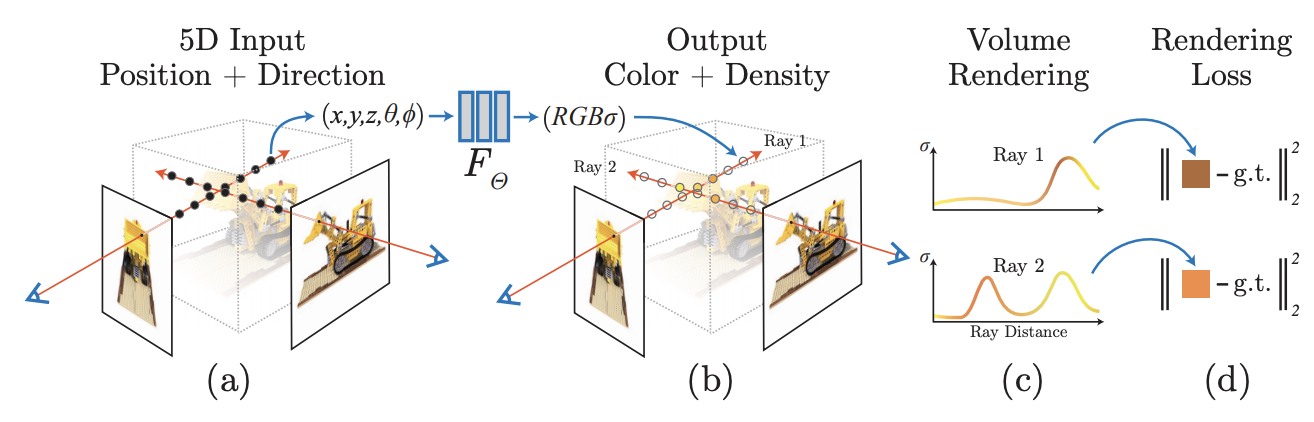

**Nerf Diagram**

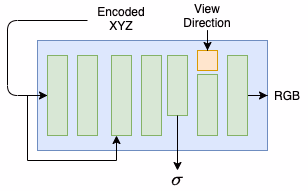

An important point here is that we predict the volume density $\sigma$ as a function of only the location x, while allowing the RGB color c to be predicted as a function of both location and viewing direction. First, the coordinates are processed with 8 fully-connected layers (ReLU activations, 256
channels), which results into $\sigma$ and a 256-dimensional feature vector representing geometry and **view-independent** spatial color. This feature vector is then concatenated with the camera ray’s viewing direction and passed to one additional fully-connected layer that outputs the **view-dependent** RGB color.

In [8]:
from IPython.display import HTML

HTML(
    """
    <video alt="nerf_view" width="1000" controls>
        <source src="http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/website_renders/viewdirs_website_bww.mp4" type="video/mp4">
    </video>
"""
)

### Harmonic embeddings

One of core ideas of NeRF is to use harmonic embeddings to enhance capturing of low-frequency details in both geometry and spatial color. Given coordinates of a point $(x, y, z)$, NeRF first applies the equation bellow to each coordinate separately obtaining $L$ coordinate representations per dim, then it concatenates these representations to the initial coordinates. It gives us an array of length $3 + L * 3$ for three dimensional case, which is then fed to the MLP.

$\gamma(x, L)=\left[\sin (\pi x), \cos (\pi x), \sin (2 \pi x), \cos (2 \pi x), \ldots, \sin \left(2^{L-1} \pi x\right), \cos \left(2^{L-1} \pi x\right)\right]$, where $L$ is a pre-defined parameter

The purpose of the illustration below is to show that lifting the input observation to higher dimensions makes it easier for network to learn detailed things. Generally, it means that training with raw (x, y) results in blurry reconstructions while adding gamma encoding shows dramatic improvements in the results i.e. it is able to preserve the sharp edges in the image.

Please see these papers for interesting insights: 
- https://bmild.github.io/fourfeat/
- https://vsitzmann.github.io/siren/



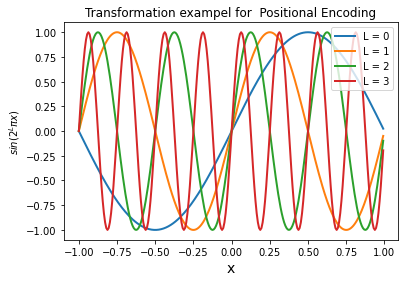

In [9]:
W = 256

x = np.linspace(0, W - 1, W)
x = (x * 1.0 / W) * 2 - 1

L = 4


for el in range(0, L):
    y = np.sin(2**el * np.pi * x)
    plt.plot(x, y, label=str("L = {}").format(el), linewidth=2)

plt.title("Transformation exampel for  Positional Encoding")
plt.xlabel("x", fontsize=14)
plt.ylabel("$sin(2^L \pi x$)", fontsize=10)
plt.legend(loc="upper right")
plt.savefig("sin.png", figsize=(10, 5), dpi=100)
plt.show()

In [10]:
!ls nerf_synthetic/lego

test   transforms_test.json   transforms_val.json
train  transforms_train.json  val


In [11]:
root = "nerf_synthetic/lego"
main = "transforms_test.json"

In [12]:
ex_dataset = BlenderDataset("nerf_synthetic/lego/", img_wh=[100, 100])
print(f"Number of pixels: {len(ex_dataset)}")

Number of pixels: 1000000


In [13]:
class Embedder(nn.Module):
    """
    Defines a function that embeds x to (x, sin(2^k x), cos(2^k x), ...)
    (Different from the paper, prepend input 'x' by default)
    Args:
        input_channels (int): number of input channels
        num_freqs (int): `L_d=4` for viewing direcion, `L_x=10` for 3D-coordinate
        log_scale (bool):
        First take power of 2 for 0 to 9 and then split equally (log_scale=False)
        or choose to generate 0-9 first and then take power of 2 separately
    """

    def __init__(
        self,
        input_channels,
        num_freqs,
    ):
        super(Embedder, self).__init__()
        self.num_freqs = num_freqs
        self.input_channels = input_channels
        self.encode_fn = [torch.sin, torch.cos]
        self.output_channels = input_channels * (len(self.encode_fn) * num_freqs + 1)
        self.freq_bands = torch.linspace(1, 2 ** (num_freqs - 1), num_freqs)

    def forward(self, x):
        """
        Inputs:
            x: (ray_cnt, num_sample, self.in_channels)
        Outputs:
            out: (ray_cnt, num_sample, self.out_channels)
        """
        out = [x]
        for freq in self.freq_bands:
            for func in self.encode_fn:
                out += [func(freq * x)]

        return torch.cat(out, -1)

### NeRF implementation

In [14]:
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, in_channels_xyz=63, in_channels_dir=27, skips=[4]):
        """
        D: number of layers for density (sigma) encoder
        W: number of hidden units in each layer
        in_channels_xyz: number of input channels for xyz (3+3*10*2=63 by default)
        in_channels_dir: number of input channels for direction (3+3*4*2=27 by default)
        skips: add skip connection in the Dth layer
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.in_channels_xyz = in_channels_xyz
        self.in_channels_dir = in_channels_dir
        self.skips = skips

        # xyz encoding layers
        for i in range(D):
            if i == 0:
                layer = nn.Linear(self.in_channels_xyz, W)
            elif i in skips:
                layer = nn.Linear(self.in_channels_xyz + W, W)
            else:
                layer = nn.Linear(W, W)
            layer = nn.Sequential(layer, nn.ReLU(True))
            setattr(self, f"xyz_encoding_{i+1}", layer)
        self.xyz_encoding_final = nn.Linear(W, W)

        # direction encoding layers
        self.dir_encoding = nn.Sequential(
            nn.Linear(self.in_channels_dir + W, W // 2),
            nn.ReLU(True),
        )

        # output layers
        self.sigma = nn.Linear(W, 1)
        self.rgb = nn.Sequential(nn.Linear(W // 2, 3), nn.Sigmoid())

    def forward(self, x, sigma_only=False):
        """
        Encodes input (xyz+dir) to rgb+sigma (not ready to render yet).
        For rendering this ray, please see Renderer.py
        Inputs:
            x: (B, self.in_channels_xyz(+self.in_channels_dir))
               the embedded vector of position and direction
            sigma_only: whether to infer sigma only. If True,
                        x is of shape (B, self.in_channels_xyz)
        Outputs:
            if sigma_only:
                sigma: (B, 1) sigma
            else:
                out: (B, 4), rgb and sigma
        """
        if not sigma_only:
            input_xyz, input_dir = torch.split(
                x, [self.in_channels_xyz, self.in_channels_dir], dim=-1
            )
        else:
            input_xyz = x

        xyz_ = input_xyz
        for i in range(self.D):
            if i in self.skips:
                xyz_ = torch.cat([input_xyz, xyz_], -1)
            xyz_ = getattr(self, f"xyz_encoding_{i+1}")(xyz_)

        sigma = self.sigma(xyz_)
        if sigma_only:
            return sigma

        xyz_encoding_final = self.xyz_encoding_final(xyz_)

        dir_encoding_input = torch.cat([xyz_encoding_final, input_dir], -1)
        dir_encoding = self.dir_encoding(dir_encoding_input)
        rgb = self.rgb(dir_encoding)
        out = torch.cat([rgb, sigma], dim=-1)
        return out

In [15]:
class NeRFSystem(LightningModule):
    def __init__(self, hparams):
        super(NeRFSystem, self).__init__()
        self.params = hparams

        self.num_workers = 10
        self.loss = nn.MSELoss(reduction="mean")

        self.embedder_xyz = Embedder(
            input_channels=3,
            num_freqs=10,
        )
        # Question: How many input coord will we have?
        self.embedder_dir = Embedder(
            input_channels=3,
            num_freqs=4,
        )
        self.sampler = RaySampleInterval(hparams["N_samples"], device=self.device)
        self.embeddings = {
            "xyz": self.embedder_xyz,
            "dir": self.embedder_dir,
        }

        self.models = NeRF(in_channels_xyz=hparams["in_feat"])
        self.img_wh = hparams["img_wh"]
        # rendering module
        self.volume_renderer = VolumeRenderer(
            train_radiance_field_noise_std=hparams["noise_std"],
            val_radiance_field_noise_std=0,
            white_background=hparams["white_back"],
            attenuation_threshold=1e-5,
            device=self.device,
        )

    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def forward(self, ray_batch):
        """Does a prediction for a batch of rays.
        Args:
            x: Tensor of camera rays containing position, direction and bounds.
        Returns: Tensor with the calculated pixel value for each ray.
        """

        def inference(
            model, embedder_xyz, xyz, embedder_dir, expanded_rays_dir, device
        ):
            """
            Helper function that performs model inference.
            Inputs:
                model: NeRF model (coarse or fine)
                embedder_xyz: embedding module for xyz
                xyz: (N_rays, N_samples_, 3) sampled positions
                    N_samples_ is the number of sampled points in each ray;
                                = N_samples for coarse model
                                = N_samples+N_importance for fine model
                embedder_dir: embedding module for direction
                expanded_rays_dir: (N_rays, N_samples, 3) :expanded ray directions
            Outputs:
                if sigma_only:
                    radience_field:(N_rays, N_samples, 1)
                else:
                    radience_field:(N_rays, N_samples, 3+1)
            """
            assert (
                xyz.shape[0] == expanded_rays_dir.shape[0]
            ), "Number of ray differ in coordinate and directions!"
            N_rays = xyz.shape[0]
            assert (
                xyz.shape[1] == expanded_rays_dir.shape[1]
            ), "Number of samples differ in coordinate and directions!"
            N_samples = xyz.shape[1]
            # Flatten the first two dimensions -> (N_rays * N_samples, 3)
            xyz_ = xyz.view(-1, 3)  # (N_rays*N_samples_, 3)
            expanded_rays_dir = expanded_rays_dir.contiguous()
            # (N_rays*N_samples_, 3)
            expanded_rays_dir_ = expanded_rays_dir.view(-1, 3)

            xyz_embedded = embedder_xyz(xyz_)  # (N_rays*N_samples_, 63)
            # (N_rays*N_samples_, 27)
            dir_embedded = embedder_dir(expanded_rays_dir_)

            xyzdir_embedded = torch.cat((xyz_embedded, dir_embedded), dim=-1).to(device)
            radiance_field = model(xyzdir_embedded)
            radiance_field = torch.reshape(radiance_field, (N_rays, N_samples, -1)).to(
                device
            )
            return radiance_field

        # both (N_rays, N_sample, 3)
        ray_origins, ray_directions = ray_batch[:, 0:3], ray_batch[:, 3:6]
        # both (N_rays, N_sample, 1)
        near, far = ray_batch[:, 6:7], ray_batch[:, 7:8]

        # Generating depth samples
        ray_count = ray_directions.shape[0]
        ray_depth_values = self.sampler(
            ray_count=ray_count,
            near=near,
            far=far,
            lindisp=self.params["lindisp"],
            perturb=self.params["perturb"],
        )
        # Samples across each ray (N_rays, N_sample, 3)
        ray_points = intervals_to_ray_points(
            ray_depth_values, ray_directions, ray_origins
        )

        # Expand rays to match batch size
        expanded_ray_directions = ray_directions[..., None, :].expand_as(ray_points)
        # Coarse inference
        coarse_radiance_field = inference(
            model=self.models,
            embedder_xyz=self.embedder_xyz,
            embedder_dir=self.embedder_dir,
            xyz=ray_points,
            expanded_rays_dir=expanded_ray_directions,
            device=self.device,
        )
        coarse_rgb = self.volume_renderer(
            coarse_radiance_field,
            ray_depth_values,
            ray_directions,
        )  # volume rendering

        return coarse_rgb

    def setup(self, stage):
        kwargs = {"root_dir": self.params["root_dir"], "img_wh": tuple(self.img_wh)}

        self.train_dataset = BlenderDataset(split="train", **kwargs)
        self.val_dataset = BlenderDataset(split="val", **kwargs)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(
            get_parameters(self.models), lr=5e-3, betas=(0.9, 0.999)
        )
        return [self.optimizer]

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            shuffle=True,
            num_workers=self.num_workers,
            batch_size=self.params["batch_size"],
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            shuffle=False,
            num_workers=self.num_workers,
            # validate one image (H*W rays) at a time
            batch_size=1,
            pin_memory=True,
        )

    def training_step(self, batch, batch_nb):
        rays, rgbs = batch["rays"], batch["rgbs"]

        results = self.forward(rays)
        loss = self.loss(results, rgbs)

        with torch.no_grad():
            psnr_coarse = psnr(self.loss(results, rgbs))

        self.log("train/loss", loss)
        self.log("train/psnr_coarse", psnr_coarse, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_nb):
        rays, rgbs = batch["rays"], batch["rgbs"]
        rays = rays.squeeze()  # (H*W, 3)
        rgbs = rgbs.squeeze()  # (H*W, 3)
        results = self.forward(rays)
        log = {"val_loss": self.loss(results, rgbs)}

        if batch_nb == 0:
            W, H = self.img_wh
            plt.subplot(121)
            plt.imshow(results.view(H, W, 3).cpu().numpy())
            plt.axis("off")
            plt.subplot(122)
            plt.imshow(rgbs.view(H, W, 3).cpu().numpy())
            plt.axis("off")
            plt.show()

        psnr_ = psnr(self.loss(results, rgbs))
        log["val_psnr"] = psnr_

        return log

    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        mean_psnr = torch.stack([x["val_psnr"] for x in outputs]).mean()

        self.log("val/loss", mean_loss)
        self.log("val/psnr", mean_psnr, prog_bar=True)

### Training

In [16]:
args = {
    "batch_size": 2400,
    "noise_std": 0,
    "white_back": True,
    "lindisp": False,
    "perturb": True,
    "in_feat": 63,
    "img_wh": [150, 150],
    "root_dir": "nerf_synthetic/lego/",
    "N_samples": 64,
}

In [17]:
system = NeRFSystem(args)

In [18]:
epochs = 5
ckpt_path = None
trainer = Trainer(
    max_epochs=epochs,
    resume_from_checkpoint=ckpt_path,
    gpus=1,
    weights_summary=None,
    progress_bar_refresh_rate=1,
    num_sanity_val_steps=1,
    check_val_every_n_epoch=1,
    benchmark=False,
    profiler=None,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Sanity Checking: 0it [00:00, ?it/s]

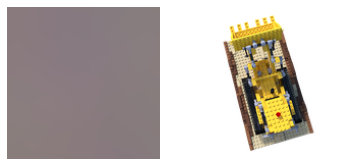

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

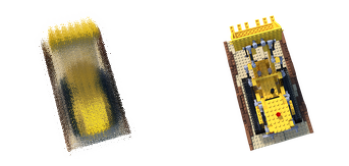

Validation: 0it [00:00, ?it/s]

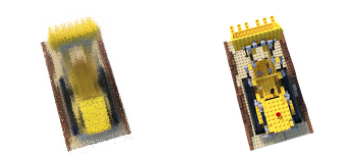

Validation: 0it [00:00, ?it/s]

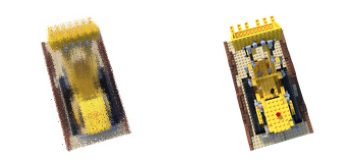

Validation: 0it [00:00, ?it/s]

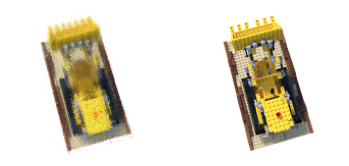

In [ ]:
trainer.fit(system)

In [ ]:
torch.save(system.models.state_dict(), "model.pt")

In [ ]:
from base64 import b64encode

import imageio
from IPython.display import HTML


def show_vid(frames, path="video.mp4"):
    imageio.mimwrite(path, frames, fps=30, quality=7)
    mp4 = open(path, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(
        """
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
    """
        % data_url
    )

In [ ]:
def trans_t(t):
    t = torch.as_tensor(t)
    return torch.tensor(
        [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, t], [0, 0, 0, 1]], dtype=torch.float
    )


def rot_phi(phi):
    phi = torch.as_tensor(phi)
    return torch.tensor(
        [
            [1, 0, 0, 0],
            [0, torch.cos(phi), -torch.sin(phi), 0],
            [0, torch.sin(phi), torch.cos(phi), 0],
            [0, 0, 0, 1],
        ],
        dtype=torch.float,
    )


def rot_theta(theta):
    theta = torch.as_tensor(theta)
    return torch.tensor(
        [
            [torch.cos(theta), 0, -torch.sin(theta), 0],
            [0, 1, 0, 0],
            [torch.sin(theta), 0, torch.cos(theta), 0],
            [0, 0, 0, 1],
        ],
        dtype=torch.float,
    )


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi / 180.0 * np.pi) @ c2w
    c2w = rot_theta(theta / 180.0 * np.pi) @ c2w
    c2w = (
        torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]).float()
        @ c2w
    )
    return c2w

In [ ]:
N_SAMPLES = 32
H = W = 150
frames = []
system = system.cuda()
for th in tqdm(np.linspace(0.0, 360.0, 120, endpoint=False)):
    c2w = pose_spherical(th, -30.0, 4.0)

    rays_o, rays_d = get_rays_with_dir(system.train_dataset.dir_cam, c2w[:3, :4])

    near = 2.0
    far = 6.0
    rays = torch.cat(
        [
            rays_o,
            rays_d,
            near * torch.ones_like(rays_o[:, :1]),
            far * torch.ones_like(rays_o[:, :1]),
        ],
        1,
    )  # (H*W, 8)

    with torch.no_grad():
        rgb = system(rays.cuda())
        # rgb = render_rays(model, rays_o.cuda(), rays_d.cuda(), near=2., far=6., n_samples=N_SAMPLES)
    # frames.append(())
    frames.append(
        (255 * np.clip(rgb.view(H, W, 3).cpu().numpy(), 0, 1)).astype(np.uint8)
    )

In [ ]:
show_vid(frames)

In [ ]:
del frames